## Construindo um Ensemble e treinando o modelo

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas do sklearn usadas para ajustar o treinamento do modelo
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
pd.set_option('display.max_columns', None)

data = pd.read_csv('HR_Analytics.csv', sep=',', encoding='utf-8')
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [4]:
# Selecionar apenas as características (excluindo a variável alvo)
feature_columns = [col for col in data.columns if col != 'Attrition']

# Atributos e alvo
X = data[feature_columns]
y = data['Attrition']

# Divisão dos dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [5]:
# Pipeline para pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), X_train.select_dtypes(include=['object']).columns),
        ('num', StandardScaler(), X_train.select_dtypes(include=['int64']).columns)
    ],
    remainder='passthrough'
)

In [6]:
# Definir hiperparâmetros para os modelos base
decisiontree_params = {
    'max_depth': 5, 
    'min_samples_split': 2, 
    'min_samples_leaf': 1,
}

randomforest_params = {
    'n_estimators': 100, 
    'max_depth': None, 
    'min_samples_split': 2, 
    'min_samples_leaf': 1, 
    'random_state': 42
}

gradientboosting_params = {
    'n_estimators': 100, 
    'learning_rate': 0.1, 
    'max_depth': 3, 
    'min_samples_split': 2, 
    'min_samples_leaf': 1, 
    'random_state': 42
}


In [7]:
# Instanciar os modelos base
# ** -> serve para descompactar o dicionário, fazendo com que os parametros possam ser acessados
base_models = [
    ('DecisionTree', DecisionTreeClassifier(**decisiontree_params)),
    ('RandomForest', RandomForestClassifier(**randomforest_params)),
    ('GradientBoosting', GradientBoostingClassifier(**gradientboosting_params))
]

meta_model = LogisticRegression()

#### Instanciando o Stacking

In [8]:
# Instanciar o modelo de stacking
stacking_ensemble = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model
)

In [9]:
# Pipeline completo com pré-processamento e modelo
model_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', stacking_ensemble)
    ]
)

##### Treinamento do modelo

In [10]:
# Treinar o modelo de stacking
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount',
       'EmployeeNumber'...
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object'))])),
                ('classifier',
                 StackingClassifier(estimators=[('DecisionTree',
                                                 DecisionTreeClassifier(max_depth=5)),
                                                ('RandomForest',
                                                 RandomForestClassifier(random_state=42)),
                                                ('GradientBoosting',
                                                 GradientBoostingClassifier(random_state=42))],
                                    final_estimator=LogisticRegression()))])

In [11]:
y_pred = model_pipeline.predict(X_test)

In [12]:
# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(classification_report(y_test, y_pred))

Accuracy: 0.8435374149659864
              precision    recall  f1-score   support

          No       0.87      0.96      0.91       370
         Yes       0.53      0.24      0.33        71

    accuracy                           0.84       441
   macro avg       0.70      0.60      0.62       441
weighted avg       0.81      0.84      0.82       441



##### Matriz de confusão

Text(0.5, 1.0, 'Confusion Matrix')

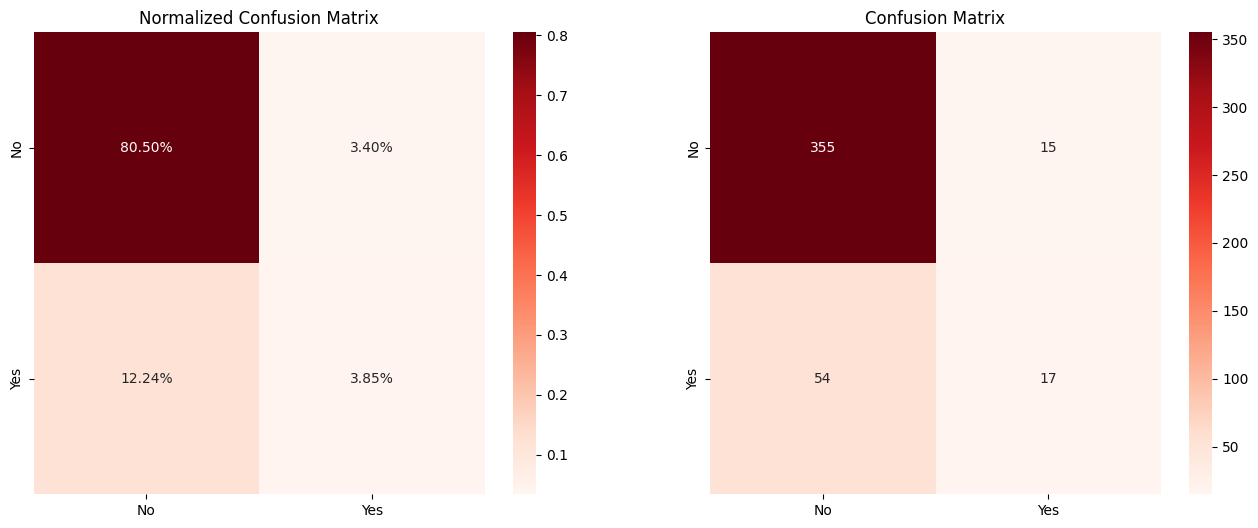

In [13]:
# Calcula a matriz de confusão normalizada
cm = confusion_matrix(y_test, y_pred)
cm_normalized = confusion_matrix(y_test, y_pred, normalize='all')

# Define a figura com dois subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plota a matriz de confusão com as proporções
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap='Reds', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'], ax=axs[0])
axs[0].set_title('Normalized Confusion Matrix')

# Plota a matriz de confusão sem normalização
sns.heatmap(cm, annot=True, fmt="d", cmap='Reds', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'], ax=axs[1])
axs[1].set_title('Confusion Matrix')
